<p><img src="https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png" width="100" align="center"></p>

# Procesamiento de texto 

## Ingeniería de Características 

### Maestría en Ciencia de Datos 
### Universidad de Sonora



#### Julio Waissman Vilanova (julio.waissman@unison.mx)




El correcto procesamiento de texto es un paso escencial para cualquier tarea de Procesamiento del Lenguaje Natural (PLN). En no pocas ocasiones, la calidad de los resultados se encuentra intimamente relacionada con ésta tarea. Sin embargo, después de la obtención de documentos (una tarea aún más ingrata) esta es una de las tareas menos glamorosa. 

Hay una serie de desiciones que hay que tomar desde esta etapa, y algunas veces es necesario volver a estas instancias para poder obtener un resultado satisfactorio.

## 1. Normalización

### Expresiones regulares en python

La limpieza de texto es un paso crucial, el cual se da a lo largo de todo el procesamiento de texto. Vamos a revisar algunos de los métodos más usuales basados en reglas, los cuales tienen que ver con el manejo de expresiones regulares. Para mayor información sobre expresiones regulares y su uso en *python* se puede consultar el material siguiente:

- Un [*acordeon* del módulo `re` de *python*](https://www.dataquest.io/blog/large_files/python-regular-expressions-cheat-sheet.pdf). 

- Un [tutorial en español sobre el uso de `re`](https://relopezbriega.github.io/blog/2015/07/19/expresiones-regulares-con-python/)

El compilador de expresiones regulares viene con varias banderas de compilación, entre las que destacan `re.I` (para ignorar el uso de mayúsculas y minúsculas); `re.S`, para que el punto signifique cualquier caracter, incluido `\n` (muy práctico en la secuancia `.*` en multiples lineas); `re.M` que permite la búsqueda en múltiples lineas, afectando la operación de los caracteres `^` y `$`; y por último `re.X` para poder representar la expresión regular en forma *verbose* (o verborreica). 

Vamos a hacer algunos ejemplos de expresiones regulares para practicar. Primero, vamos a compilar y explicar algunas fórmulas que típicamente son muy útiles en PLN. 


In [1]:
import re

email_re = re.compile(r"""
\b               # comienzo de delimitador de palabra
[\w-][\w\.-]*  # Cualquier caracter alfanumerico seguido de uno o mas caracteres mas los signos (. -)
@                # seguido de @
\w[\w\.-]*      # cualquier caracter alfanumerico mas los signos (.-)
\.               # seguido de .
[a-zA-Z]{2,6}    # dominio de alto nivel: 2 a 6 letras en minúsculas o mayúsculas.
\b               # fin de delimitador de palabra
""", re.X)

url_re = re.compile(r"""
\b                  # delimitador de palabra
(\w+:\/{2})?        # caracteres iniciales (http, https, ftp, ...) seguidos de // (uno o ninguno)
[\d\w-]+            # cualquier caracter alfanumerico mas -
(\.[\d\w-]+)+       # seguido de uno o mas dominios, que empiezan con punto y siguen con caracteres
(/\S+)*             # cualquier serie de caracteres separados por / y sin espacios en blanco
\b                  # delimitador de palabra
""", re.X) 

insulto_re = re.compile(r"""
([#%&\*\$]{2,})     # al menos dos simbolos típicos para poner insultos
(\w*)               # seguidos de letras
""", re.X)

y a hora vamos a probar algunos de estas expresiones regulares. Esta herramienta de `nltk` es muy
util para verificar que se armaron las expresiones regulares de forma correcta.

In [2]:
texto_en_bruto ="""
Como la mayoría sabréis, un sitio Web “normal” tiene una URL en este formato: 
http://www.ordenadores-y-portatiles.com. Habrás notado que www.ordenadores-y-portatiles.com 
sigue llegando sin ningún problema al sitio. que es diferente que
www.ordenadores-y-portatiles.com/una%20rireccion/de%20prueba/pagina.html
Nos podemos encontrar otros formatos como es el caso de FTP, como por ejemplo 
ftp.microsoft.com en modo comando o ftp://ftp.microsoft.com si lo ponemos en un 
navegador de Internet. Tambien se puede accesar por su IP como en  217.76.130.207, 

Para los correos electrónicos, si tienes uno en gmail, lo puede poner como
juliowaissman@gmail.com, JulioWaissman@gmail.com, julio.waissman@gmail.com,
Julio.Waissman@gmail.com, y todos te llevan al mismo lado. Igual se puede tener
correos un poco extraños como w234QWSA.dojdnn_wsda@unison.edu.mx, y deberíamos
poder reconocerlos (entre otros)
"""

# La utilería no funciona con expresiones regulares compiladas
email_re_str = r"\b[\w-][\w\.-]*@\w[\w\.-]*\.[a-zA-Z]{2,6}\b"
url_re_str = r"\b(\w+:\/{2})?\b[\d\w-]+(\.[\d\w-]+)+(/\S+)*\b"

re.findall(email_re_str, texto_en_bruto)

['juliowaissman@gmail.com',
 'JulioWaissman@gmail.com',
 'julio.waissman@gmail.com',
 'Julio.Waissman@gmail.com',
 'w234QWSA.dojdnn_wsda@unison.edu.mx']

Ahora, vamos a hacer algunas expresiones regulares para detectar emoticones (algo particularmente útil en tratamiento de textos en redes sociales).

In [3]:
emo_gde_feliz_re = re.compile(r' [8x;:=]-?(?:\)|\}|\]|>){2,}')
emo_chi_feliz_re = re.compile(r' (?:[;:=]-?[\)\}\]d>])|(?:<3)|(?:XOXO)')
emo_gde_triste_re = re.compile(r' [x:=]-?(?:\(|\[|\||\\|/|\{|<){2,}')
emo_chi_triste_re = re.compile(r' [x:=]-?[\(\[\|\\/\{<]')

**Inventa un texto en bruto con diferentes emojis y substituye los emojis por los tokens `:BHAPPY:`, `:SHAPPY:`, `BSAD:`, `:SSAD` segun corresponda.** 

In [4]:
# ---- Inserta tu código aqui ------

### Tratamiento de texto

Ahora vamos a utilizar las expresiones regulares para tratar un conjunto de documentos, para utilizarlos posteriormente en una tarea de ciencia de datos. Vamos a usar los datos de los tweets del concurso TASS 2015 que se encuentran disponibles para el desarrollo y prueba de sistemas de análisis de sentimientos de manera libre. Para esto, vamos a procesar el corupus de entrenamiento,el cual viene en formato `xml`.

In [5]:
import xml.etree.ElementTree as et
import pandas as pd

archivo = "general-tweets-train-tagged.xml"

arbol = et.parse(archivo)
raiz = arbol.getroot()
data_dic = []
for tweet in raiz.iter('tweet'):
    contenido = tweet.find('content').text
    if contenido is not None:
        data_dic.append({
            'texto': contenido,
            'polaridad': tweet.find('sentiments')[0].find('value').text,
            'id': tweet.find('tweetid').text,
            'usuario': '@' + tweet.find('user').text,
            'fecha': tweet.find('date').text,
            'tópicos': '[' + ', '.join(['"' + t.text + '"' for t in tweet.find('topics')]) + ']'
        })
df_train = pd.DataFrame.from_dict(data_dic)
display(df_train.head(10))

,texto,polaridad,id,usuario,fecha,tópicos
0,"Salgo de #VeoTV , que día más largoooooo...",NONE,142389495503925248,@ccifuentes,2011-12-02T00:47:55,"[""otros""]"
1,@PauladeLasHeras No te libraras de ayudar me/n...,NEU,142389933619945473,@CarmendelRiego,2011-12-02T00:49:40,"[""otros""]"
2,@marodriguezb Gracias MAR,P,142391947707940864,@CarmendelRiego,2011-12-02T00:57:40,"[""otros""]"
3,"Off pensando en el regalito Sinde, la que se v...",N+,142416095012339712,@mgilguerrero,2011-12-02T02:33:37,"[""política"", ""economía""]"
4,Conozco a alguien q es adicto al drama! Ja ja ...,P+,142422495721562112,@paurubio,2011-12-02T02:59:03,"[""otros""]"
5,"RT @FabHddzC: Si amas a alguien, déjalo libre....",NONE,142424715175280640,@paurubio,2011-12-02T03:07:52,"[""música""]"
6,Toca @crackoviadeTV3 . Grabación dl especial N...,P+,142483342040907776,@Carlos_Latre,2011-12-02T07:00:50,"[""entretenimiento""]"
7,Hoy asisitiré en Madrid a un seminario sobre l...,NONE,142493511634259968,@Ignacos,2011-12-02T07:41:15,"[""política""]"
8,Buen día todos! Lo primero mandar un abrazo gr...,P+,142494476051562496,@nacho_uriarte,2011-12-02T07:45:05,"[""otros""]"
9,Desde el escaño. Todo listo para empezar #endi...,P+,142496796416016384,@JuanraLucas,2011-12-02T07:54:19,"[""política""]"


y vamos a quedarnos sólo con el texto:

In [6]:
x_train = [documento for documento in df_train['texto'].values]
print('Conjunto con {} entradas de tweeter para ser tratadas'.format(len(x_train)))

x_train[:20]

Conjunto con 7218 entradas de tweeter para ser tratadas


['Salgo de #VeoTV , que día más largoooooo...',
 '@PauladeLasHeras No te libraras de ayudar me/nos. Besos y gracias',
 '@marodriguezb Gracias MAR',
 'Off pensando en el regalito Sinde, la que se va de la SGAE cuando se van sus corruptos. Intento no sacar conclusiones (lo intento)',
 'Conozco a alguien q es adicto al drama! Ja ja ja te suena d algo!',
 'RT @FabHddzC: Si amas a alguien, déjalo libre. Si grita ese hombre es mío era @paurubio...',
 'Toca @crackoviadeTV3 . Grabación dl especial Navideño...Mari crismas!',
 'Hoy asisitiré en Madrid a un seminario sobre la Estrategia Española de Seguridad organizado por FAES.',
 'Buen día todos! Lo primero mandar un abrazo grande a Miguel y a su familia @libertadmontes Hoy podría ser un día para la grandeza humana.',
 'Desde el escaño. Todo listo para empezar #endiascomohoy en el Congreso http://t.co/Mu2yIgCb',
 'Bdías. EM no se ira de puente. Si vosotros os vais no dejeis de llevar la tableta o el PC y desde luego Orbyt. De momento no digo má

y el conjunto debera tener 7,218 entradas.

Ahora que ya tenemos los datos de entrada es necesario tratarlos. Para esto, es muy importante que se traten de forma homogenea, y que la forma en que los tratamos sea fácil de exportar, con el fin que sea reproducible. Es por esto que el tratamiento debe de ser siempre realizado en forma de función. Vamos a tratar nuestro texto en una función `prepara_texto`.

In [7]:
# Vaos a tratar que ver que significa cada expresión regular

usuarios_re = re.compile(r"@[\w\d]+")

hashtags_re = re.compile(r"#[\w\d]+")

remplaza_por_espacios_re = re.compile('[\n/(){}\[\]\|@,;\.]')

simbolos_a_eliminar_re = re.compile('[^\d\w #+_]')

def prepara_texto(texto):
    text = texto.lower()
    
    # Codificaciones (problemas con UTF-8, latin1, etc...)
    text = re.sub(r'\\\\', r'\\', text)
    text = re.sub(r'\\\\', r'\\', text)
    text = re.sub(r'\\x\w{2,2}', ' ', text)
    text = re.sub(r'\\u\w{4,4}', ' ', text)
    text = re.sub(r'\\n', ' . ', text)

    # Cambia e_mails, urls y usuarios por palabra clave
    text = re.sub(email_re, '_EMAIL_', text)
    text = re.sub(url_re, '_URL_', text)
    text = re.sub(usuarios_re, '_USR_', text)
    text = re.sub(hashtags_re, '_HASHTAG_', text)
    
    # Elimina etiquetas de marcaje tipo xml
    # (no se requiere en este caso pero solo para dejar el tip)
    #text = BeautifulSoup(text, "lxml").get_text() 
  
    # Las palabras con letras repetidas más de 3 veces 
    # (dos veces por las personas que abusan demasiado)
    text = re.sub(r'([a-zA-Z])\1\1+(\w*)', r'\1\1\2', text)
    text = re.sub(r'([a-zA-Z])\1\1+(\w*)', r'\1\1\2', text)
    
    # Elimina simbolos
    text = re.sub(remplaza_por_espacios_re, ' ', text)
    text = re.sub(simbolos_a_eliminar_re, '', text)
    
    return text

Ahora vamos a normalizar nuestros documentos

In [8]:
x_train_prep = [prepara_texto(documento) for documento in x_train]
x_train_prep[:20]

['salgo de _HASHTAG_   que día más largoo   ',
 '_USR_ no te libraras de ayudar me nos  besos y gracias',
 '_USR_ gracias mar',
 'off pensando en el regalito sinde  la que se va de la sgae cuando se van sus corruptos  intento no sacar conclusiones  lo intento ',
 'conozco a alguien q es adicto al drama ja ja ja te suena d algo',
 'rt _USR_ si amas a alguien  déjalo libre  si grita ese hombre es mío era _USR_   ',
 'toca _USR_   grabación dl especial navideño   mari crismas',
 'hoy asisitiré en madrid a un seminario sobre la estrategia española de seguridad organizado por faes ',
 'buen día todos lo primero mandar un abrazo grande a miguel y a su familia _USR_ hoy podría ser un día para la grandeza humana ',
 'desde el escaño  todo listo para empezar _HASHTAG_ en el congreso _URL_',
 'bdías  em no se ira de puente  si vosotros os vais no dejeis de llevar la tableta o el pc y desde luego orbyt  de momento no digo más ',
 'un sistema económico q recorta dinero para prestaciones sociales y

Así como estos ejemplos, existen otros casos en los cuales se pueden establecer reglas, basadas o no en 
expresiones regulares. Algunos casos son:

1. Etiquetas de marcaje (Markdown, $\LaTeX$, ...). 

2. Eliminación de apostrofes

3. Argot y neologísmos

Igualmente, la puntuación puede mantenerse en algunos casos (por ejemplo, los signos de exclamación e interrogación). Por otra parte, usuarios, url, correos electrónicos y demás, pueden ser eliminados en lugar de mantenerlos con una palabra clave (o inclusive, pueden ser mantenidos tal cual, si la base de datos es suficientemente amplia y el nombre del usuario es fundamental para inferir el contexto).


## 2. Tokenización

La definición de *token*, particularmente en su uso en PLN no es muy preciso. Sin embargo, hay un consenso establecido en entender un *token* como la ocurrencia individual de una unidad mínima de lenguaje. Esta unidad puede pertenecer a una diversidad de *tipos* de elementos gramaticales y su única restricción es que sea un bloque indivisible de texto útil para transmitir un mensaje. La pertinencia de esta división depende mucho del lenguaje y del contexto del mensaje que se está analizando.

En el caso de lenguajes como el español y el inglés, la estructura del lenguaje escrito es predominantemente alfabética con el uso de logogramas para representación alternativa/compacta de números y para símbolos ([sistemas de escritura](https://en.wikipedia.org/wiki/Writing_system)). En este caso, la segmentación de un texto en *tokens* es relativamente simple, utilizando caracteres de demarcación como pueden ser los espacios en blanco y los signos de puntuación.

Utilizando la biblioteca [nltk (*Natural language toolkit*)](http://www.nltk.org) de python, vamos a revisar diferentes formas de *tokenizar* a partir de este [texto](https://www.zendalibros.com/5-poemas-de-ruben-dario/) de Rubén Darío:

>Junto al negro palacio del rey de la isla de Hierro (¡Oh, cruel, horrible, destierro!) ¿Cómo es que
tú, hermana armoniosa, haces cantar al cielo gris, tu pajarera de ruiseñores, tu formidable caja musical?
¿No te entristece recordar la primavera en que oíste a un pájaro divino y tornasol
>
>en el país del sol?
>
>En el jardín del rey de la isla de Oro (¡oh, mi ensueño que adoro!) fuera mejor que tú, armoniosa
hermana, amaestrases tus aladas flautas, tus sonoras arpas; tú que naciste donde más lindos nacen el clavel de sangre y la rosa de arrebol,
>
>en el país del sol
>
>O en el alcázar de la reina de la isla de Plata (Schubert, solloza la Serenata…) pudieras también, hermana
armoniosa, hacer que las místicas aves de tu alma alabasen, dulce, dulcemente, el claro de luna, los vírgenes lirios, la monja paloma y el cisne marqués. La mejor plata se funde en un ardiente crisol,
>
>en el país del sol
>
>Vuelve, pues a tu barca, que tiene lista la vela (resuena, lira, Céfiro, vuela) y parte, armoniosa
hermana, a donde un príncipe bello, a la orilla del mar, pide liras, y versos y rosas, y acaricia sus rizos de
oro bajo un regio y azul parasol,
>
>en el país del sol



In [9]:
import nltk

el_pais_del_sol = """Junto al negro palacio del rey de la isla de Hierro (¡Oh, cruel, horrible, destierro!) ¿Cómo es que
tú, hermana armoniosa, haces cantar al cielo gris, tu pajarera de ruiseñores, tu formidable caja musical?
¿No te entristece recordar la primavera en que oíste a un pájaro divino y tornasol

en el país del sol?

En el jardín del rey de la isla de Oro (¡oh, mi ensueño que adoro!) fuera mejor que tú, armoniosa
hermana, amaestrases tus aladas flautas, tus sonoras arpas; tú que naciste donde más lindos nacen el clavel de sangre y la rosa de arrebol,

en el país del sol

O en el alcázar de la reina de la isla de Plata (Schubert, solloza la Serenata…) pudieras también, hermana
armoniosa, hacer que las místicas aves de tu alma alabasen, dulce, dulcemente, el claro de luna, los vírgenes lirios, la monja paloma y el cisne marqués. La mejor plata se funde en un ardiente crisol,

en el país del sol

Vuelve, pues a tu barca, que tiene lista la vela (resuena, lira, Céfiro, vuela) y parte, armoniosa
hermana, a donde un príncipe bello, a la orilla del mar, pide liras, y versos y rosas, y acaricia sus rizos de
oro bajo un regio y azul parasol,

en el país del sol"""

In [10]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
tokens = tokenizer.tokenize(el_pais_del_sol)
print(tokens[:60])

['Junto', 'al', 'negro', 'palacio', 'del', 'rey', 'de', 'la', 'isla', 'de', 'Hierro', '(¡Oh,', 'cruel,', 'horrible,', 'destierro!)', '¿Cómo', 'es', 'que', 'tú,', 'hermana', 'armoniosa,', 'haces', 'cantar', 'al', 'cielo', 'gris,', 'tu', 'pajarera', 'de', 'ruiseñores,', 'tu', 'formidable', 'caja', 'musical?', '¿No', 'te', 'entristece', 'recordar', 'la', 'primavera', 'en', 'que', 'oíste', 'a', 'un', 'pájaro', 'divino', 'y', 'tornasol', 'en', 'el', 'país', 'del', 'sol?', 'En', 'el', 'jardín', 'del', 'rey', 'de']


In [11]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
tokens = tokenizer.tokenize(el_pais_del_sol)
print(tokens[:60])

['Junto', 'al', 'negro', 'palacio', 'del', 'rey', 'de', 'la', 'isla', 'de', 'Hierro', '(¡', 'Oh', ',', 'cruel', ',', 'horrible', ',', 'destierro', '!)', '¿', 'Cómo', 'es', 'que', 'tú', ',', 'hermana', 'armoniosa', ',', 'haces', 'cantar', 'al', 'cielo', 'gris', ',', 'tu', 'pajarera', 'de', 'ruiseñores', ',', 'tu', 'formidable', 'caja', 'musical', '?', '¿', 'No', 'te', 'entristece', 'recordar', 'la', 'primavera', 'en', 'que', 'oíste', 'a', 'un', 'pájaro', 'divino', 'y']


In [12]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(el_pais_del_sol)
print(tokens[:60])

['Junto', 'al', 'negro', 'palacio', 'del', 'rey', 'de', 'la', 'isla', 'de', 'Hierro', '(', '¡Oh', ',', 'cruel', ',', 'horrible', ',', 'destierro', '!', ')', '¿Cómo', 'es', 'que', 'tú', ',', 'hermana', 'armoniosa', ',', 'haces', 'cantar', 'al', 'cielo', 'gris', ',', 'tu', 'pajarera', 'de', 'ruiseñores', ',', 'tu', 'formidable', 'caja', 'musical', '?', '¿No', 'te', 'entristece', 'recordar', 'la', 'primavera', 'en', 'que', 'oíste', 'a', 'un', 'pájaro', 'divino', 'y', 'tornasol']


In [13]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(el_pais_del_sol)
print(tokens[:60])

['Junto', 'al', 'negro', 'palacio', 'del', 'rey', 'de', 'la', 'isla', 'de', 'Hierro', 'Oh', 'cruel', 'horrible', 'destierro', 'Cómo', 'es', 'que', 'tú', 'hermana', 'armoniosa', 'haces', 'cantar', 'al', 'cielo', 'gris', 'tu', 'pajarera', 'de', 'ruiseñores', 'tu', 'formidable', 'caja', 'musical', 'No', 'te', 'entristece', 'recordar', 'la', 'primavera', 'en', 'que', 'oíste', 'a', 'un', 'pájaro', 'divino', 'y', 'tornasol', 'en', 'el', 'país', 'del', 'sol', 'En', 'el', 'jardín', 'del', 'rey', 'de']


Generalmente la *tokenización* se realiza internamente como un paso intermedio de otros métodos. Vamos a utilizar el *tokenizador* más simple para nuestro texto ya tratado

In [14]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
x_train_tokens = [tokenizer.tokenize(x) for x in x_train_prep]

for i in range(5):
    print(x_train_tokens[i])

['salgo', 'de', '_HASHTAG_', 'que', 'día', 'más', 'largoo']
['_USR_', 'no', 'te', 'libraras', 'de', 'ayudar', 'me', 'nos', 'besos', 'y', 'gracias']
['_USR_', 'gracias', 'mar']
['off', 'pensando', 'en', 'el', 'regalito', 'sinde', 'la', 'que', 'se', 'va', 'de', 'la', 'sgae', 'cuando', 'se', 'van', 'sus', 'corruptos', 'intento', 'no', 'sacar', 'conclusiones', 'lo', 'intento']
['conozco', 'a', 'alguien', 'q', 'es', 'adicto', 'al', 'drama', 'ja', 'ja', 'ja', 'te', 'suena', 'd', 'algo']


Y ahora analicemos un poco como está funcionando nuestro tokenizador, después de normalizar los datos

In [15]:
palabras_comunes = nltk.FreqDist(t for d in x_train_tokens for t in d)
pc_df = pd.DataFrame(palabras_comunes.most_common(50), columns=['Palabras', 'Frecuencia'])
pc_df

,Palabras,Frecuencia
0,de,5466
1,_USR_,4210
2,la,3717
3,el,3398
4,_URL_,3195
5,en,3076
6,a,2769
7,y,2481
8,que,2241
9,_HASHTAG_,1697


Populating the interactive namespace from numpy and matplotlib


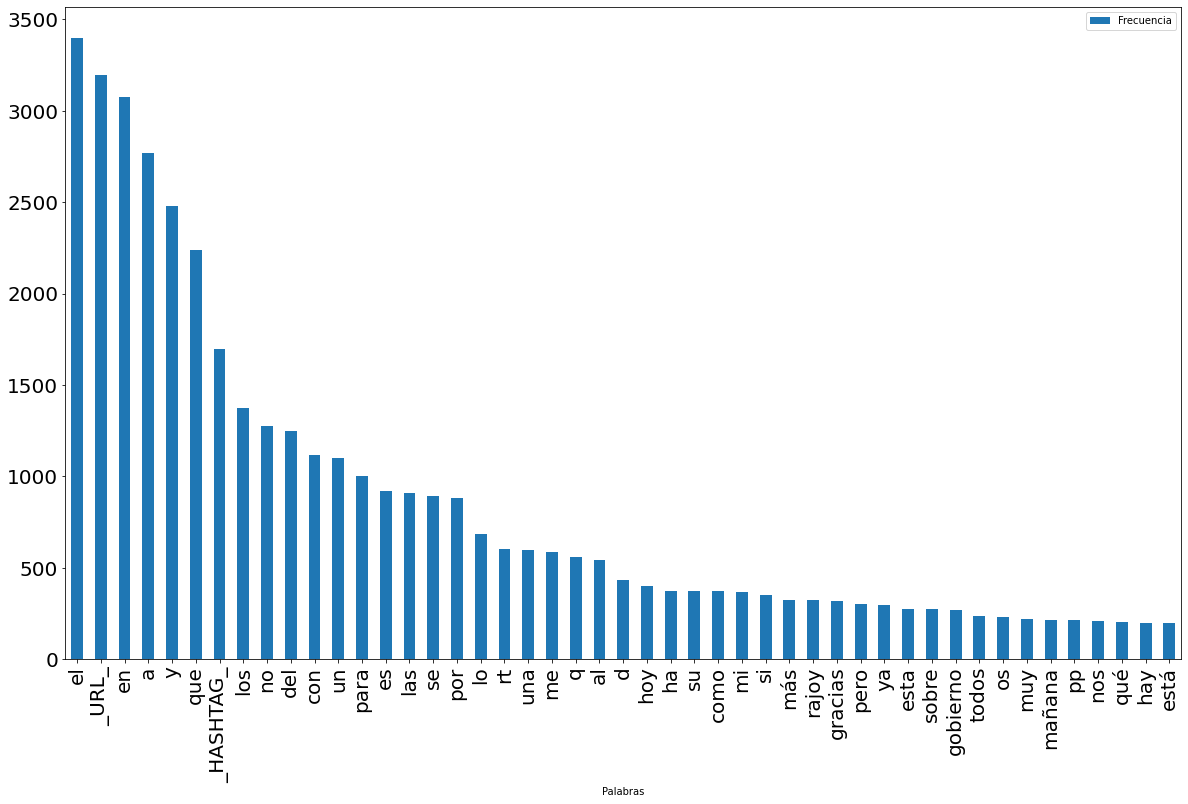

In [16]:
import matplotlib
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

pc_df.loc[3:,:].plot.bar(x='Palabras', y='Frecuencia', fontsize=20)

Como vemos, salen muchas palabras que no nos sirven para gran cosa, y eso es porque no quitamos las palabras de paro. Así que trataremos nuestros datos para quitarlas y ver como es la distribución de palabras que quedan.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/moodymcfly/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


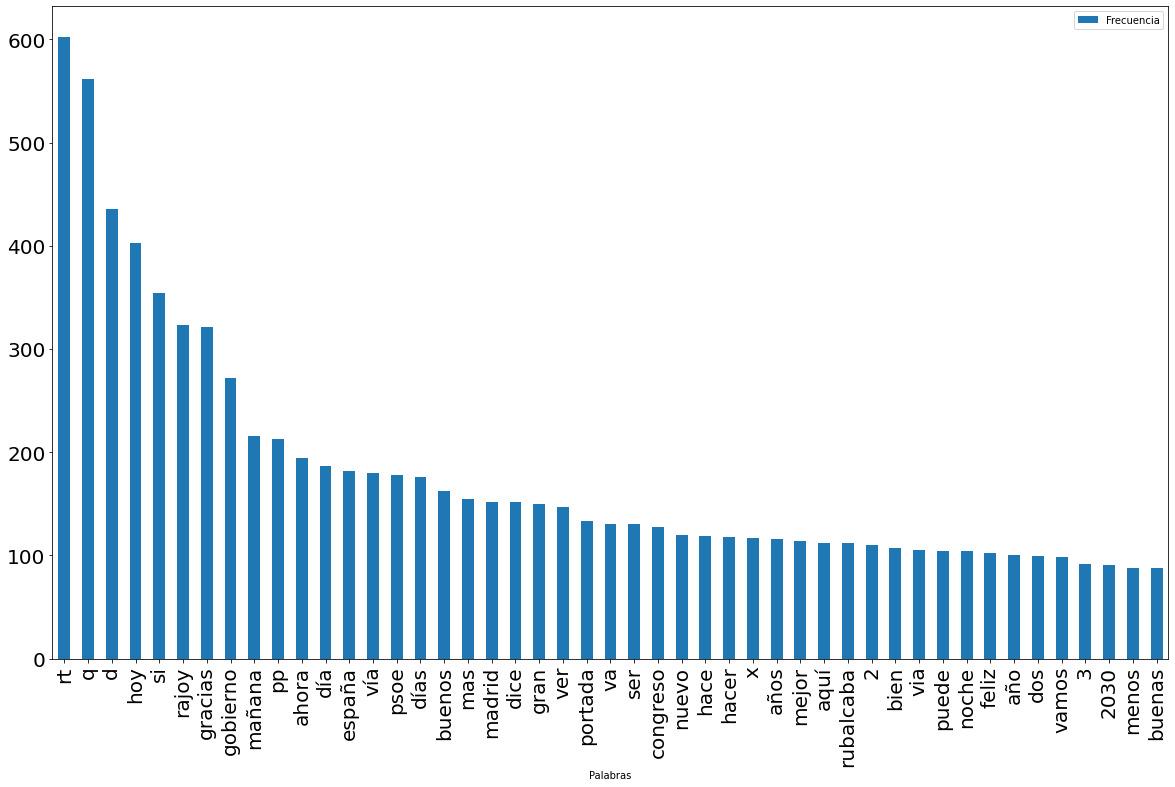

In [19]:
import nltk
nltk.download("stopwords")
palabras_paro = nltk.corpus.stopwords.words('spanish')
x_train_tokens_sw = [[palabra for palabra in tuit if palabra not in palabras_paro] for
                     tuit in x_train_tokens]

palabras_comunes = nltk.FreqDist(t for d in x_train_tokens_sw for t in d)
pc_df = pd.DataFrame(palabras_comunes.most_common(50), columns=['Palabras', 'Frecuencia'])

pc_df.loc[3:,:].plot.bar(x='Palabras', y='Frecuencia', fontsize=20)

## 2.3. *Stemming*/Lematización

El proceso de *Stemming*/Lematización tiene como fin reducir el tamaño del vocabulario, eliminando algunos casos relativamente simples, como puede ser plurl/singular o femenino/masculino en palabras simples. 

Si bien existen una cantidad importante de métodos de *stem* para inglés, existen pocos trabajos sobre esto en español. El único método de *stemming* en español bien documentado es el conocido como [*Snowball Spanish stemming algorithm](http://snowball.tartarus.org/algorithms/spanish/stemmer.html) el cual se encuentra implementado en *nltk*. 

In [20]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(el_pais_del_sol)

stemmer = nltk.stem.snowball.SpanishStemmer()
tokens_stem = [stemmer.stem(token) for token in tokens]

print(tokens_stem[:60])

['junt', 'al', 'negr', 'palaci', 'del', 'rey', 'de', 'la', 'isla', 'de', 'hierr', 'oh', 'cruel', 'horribl', 'destierr', 'com', 'es', 'que', 'tu', 'herman', 'armoni', 'hac', 'cant', 'al', 'ciel', 'gris', 'tu', 'pajarer', 'de', 'ruiseñor', 'tu', 'formid', 'caj', 'musical', 'no', 'te', 'entristec', 'record', 'la', 'primaver', 'en', 'que', 'oist', 'a', 'un', 'pajar', 'divin', 'y', 'tornasol', 'en', 'el', 'pais', 'del', 'sol', 'en', 'el', 'jardin', 'del', 'rey', 'de']


Veamos ahora que pasa si utilizamos el método de *stemming* y comparamos la dispersión de las palabras respecto a las que se generaron con el tokenizador sin más

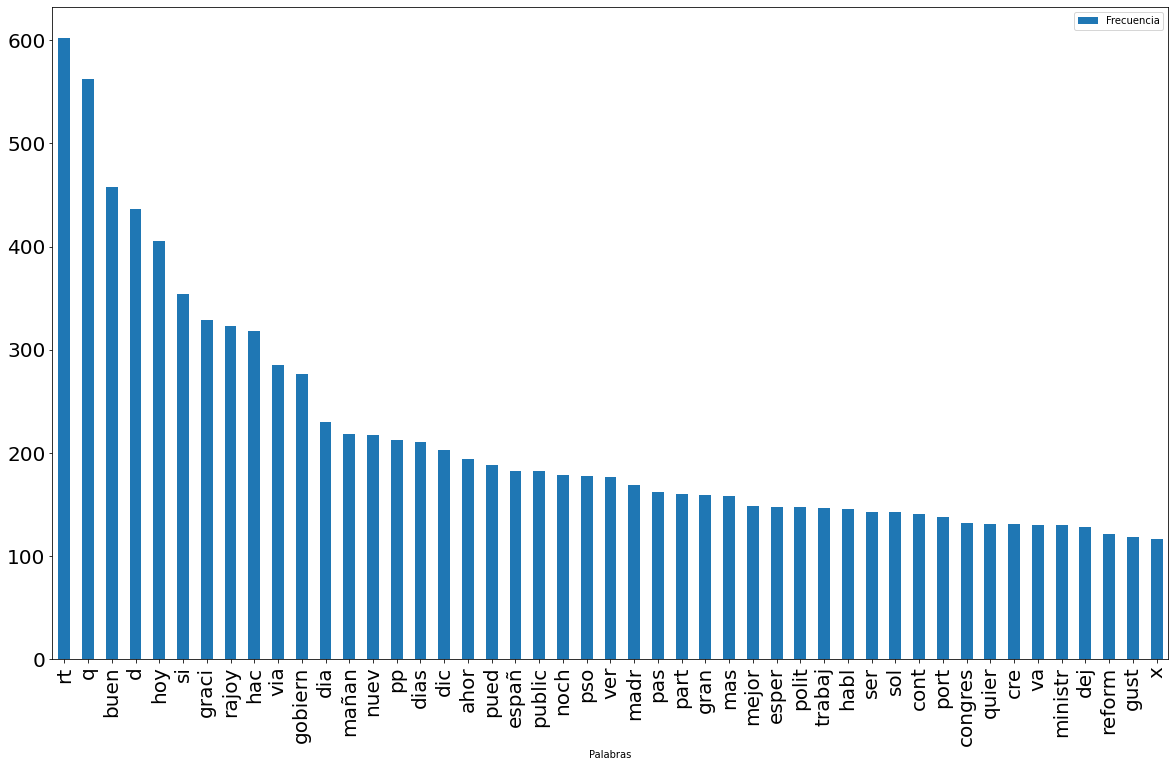

In [21]:
x_train_stem = [[stemmer.stem(token) for token in doc] for doc in x_train_tokens_sw]

pc_stem = nltk.FreqDist(t for d in x_train_stem for t in d)
pc_stem_df = pd.DataFrame(pc_stem.most_common(50), columns=['Palabras', 'Frecuencia'])
pc_stem_df.loc[3:,:].plot.bar(x='Palabras', y='Frecuencia', fontsize=20)